# Matt Sloan Data Mining Project 1

## Introduce the problem
#### Introduce the project. What is the problem you are trying to solve? What questions are you trying to find answers to?
---

I want to compare the money in/out for US Senate members and see if that impacts their chance of wining.
I hypothesize that the higher the expenditures (per registered voter per state) that the higher the odds of a candidate winning. Additionally, I want to see if candidates in states (overall) that spend more money have higher voter turnouts, think something like total votes per capita per dollar or something along those lines.
I am also interseted in seeing just how beneficial being incumbent is. (why is this text so large??)
---

## Introduce the data
#### Where did you find it. What is the data about (include links)? What are the features (with additional explanations if not already self-explanatory from the name itself)?
---

There are many many fields, and since these results and expenditure reports come from a range of years, they do tend to change over time. 
Generally though, the expenditures are the same with fields including the Candidates Federal Election Commission (FEC) ID, name, Incumbent challenger status, party code, many receipts and disbursements, beginning and ending cash, loans, debts, district, refunds and more.

The results files are the tough part with a few different layouts, the 1996 file for example is a mess. But generally they all contain State names, abbreviatrions, districts, names, FEC ID's, primary votes and percentages, general votes and percentages, and incumbent status. 

---

##### Some links
Where most of this can be found
https://www.fec.gov/data/browse-data/?tab=bulk-data

The financial fields descriptions
https://www.fec.gov/campaign-finance-data/current-campaigns-house-and-senate-file-description/

Results, form of link and then additional info avail to download on next line
https://www.fec.gov/documents/1722/FederalElections96_1996Senate.xlsx
Senate excel, vote summary pdf

https://www.fec.gov/documents/1727/FederalElections98_SenateResults.pdf
entire publication pdf

https://www.fec.gov/documents/1734/2000tables.xls
Senate, House results by state excel

https://www.fec.gov/documents/1620/2002fedresults.xls
Senate, House results excel

https://www.fec.gov/documents/1625/2004congresults.xls
entire publication excel

https://www.fec.gov/documents/1656/results06.xls
senate, house pdf. entire publication excel

https://www.fec.gov/documents/1659/2008congresults.xls
Entire publication excel

https://www.fec.gov/documents/1677/results10.xls
senate, house pdf. entire publication excel

https://www.fec.gov/documents/1682/2012congresults.xls
entire publicatin excel

https://www.fec.gov/documents/1705/results14.xls
entire publication excel. senate, house pdf

https://www.fec.gov/documents/1890/federalelections2016.xlsx
no other options

https://www.fec.gov/documents/2706/federalelections2018.xlsx
no other options

2020 - only presidential ?

In [1]:
# These functions will put together the urls for downloading the budget txt files and also download the xls files for the election results
# Also loads the standard python libraries in case the data files aren't already available in the data/ directory

# to download files
import requests
# to check if dir/files exist (do we need to download them?)
import os
# some of these are zips, we must unzip
import zipfile

# Function generate URL, download and unzip
def download_file(_year: int):
    
    shortyear = str(_year)[-2:] # 1996 -> 96
    url1 = 'https://www.fec.gov/files/bulk-downloads/'
    url2 = str(_year)
    url3 = '/webl'
    url4 = shortyear
    url5 = '.zip'
    
    URL = url1+url2+url3+url4+url5
    
    r = requests.get(URL)
    
    # Download from url https://requests.readthedocs.io/en/latest/
    with open("data/webl" + str(shortyear) + ".zip", "wb") as f:
        f.write(r.content)
        
    # unzip downloaded file https://www.pythonpool.com/python-unzip/
    try:
        with zipfile.ZipFile("data/webl" + shortyear + ".zip") as z:
            z.extractall("data/")
    except:
        print("error:" + "webl" + shortyear)
        
    # Function to download all of the results
def download_results():
    # Download all of the results
    RESULTS_URLS = ('https://www.fec.gov/documents/2706/federalelections2018.xlsx', 'https://www.fec.gov/documents/1890/federalelections2016.xlsx', 'https://www.fec.gov/documents/1705/results14.xls', "https://www.fec.gov/documents/1682/2012congresults.xls", "https://www.fec.gov/documents/1677/results10.xls", "https://www.fec.gov/documents/1659/2008congresults.xls", "https://www.fec.gov/documents/1656/results06.xls", "https://www.fec.gov/documents/1625/2004congresults.xls", "https://www.fec.gov/documents/1620/2002fedresults.xls", "https://www.fec.gov/documents/1616/2000house.xls", "https://www.fec.gov/documents/1615/2000senate.xls", "https://www.fec.gov/documents/1727/FederalElections98_SenateResults.pdf", "https://www.fec.gov/documents/1722/FederalElections96_1996Senate.xlsx")
    
    for link in RESULTS_URLS:
        r = requests.get(link)
        with open("data/" + link[link.rindex("/")+1:], "wb") as f:
            f.write(r.content)

In [2]:
# Use the above defined functions to download the files if they're not already in data/
# If this is the first time running, we need the dir and files

if not os.path.exists("data/"):
    os.mkdir("data/")
    
    # Some needed variables for downloading
    START_YEAR = 1996
    END_YEAR = 2022
    YEAR_LIST = range(START_YEAR, END_YEAR + 2, 2)


    # download and unzip all of these files
    for year in YEAR_LIST:
        download_file(year)
        
    download_results()

#### Putting all of these goods into a df

In [3]:
import pandas as pd
import numpy as np

# We need to seperate the xlsx/pdf files from the txt
all_files = os.listdir("data/")
# results_list = []
expenditures_list = []

for file_name in all_files:
    # if file_name[-4:] == ".xls" or file_name[-5:] == ".xlsx":# or file_name[-4:] == ".pdf":
    #     results_list.append("data/" + file_name)
    if file_name[-4:] == ".txt":
        expenditures_list.append("data/" + file_name)

# 

## Pre-processing the data
#### What pre-processing steps do you follow? Explain why you do each pre-processing step.
---
The first step of course is putting all these files into dataframes. 
Some of these results files have multiples sheets so I intend to:
* split the sheets up into their own df's to make them more manageable
* rid of columns I will not be using to start to bring together a usuable df
* rid of rows with entire NaN values
Luckily the finance files are generally the same and just dilimitted with | 
* remove unneeded columns
* remove candidates that are not also in the results (for example they ran a campaign but didn't even make it to the primaries)

Afterwards, I plan to have each candidate for every year that was in the primaries and general elections in a single df along with their campaign finance data.

Additionally it looks like NC held a special election from 2018 that was in 2019? I need to look into that... TODO: 

---

In [4]:
# print(results_list)
print(expenditures_list)

['data/webl96.txt', 'data/webl18.txt', 'data/webl16.txt', 'data/webl00.txt', 'data/webl02.txt', 'data/webl06.txt', 'data/webl12.txt', 'data/webl20.txt', 'data/webl08.txt', 'data/webl14.txt', 'data/webl10.txt', 'data/webl98.txt', 'data/webl04.txt', 'data/webl22.txt']


In [5]:
# These files do not include headers to name our columns
# So I pulled these from the 

exp_colm_names = ['CAND_ID', 'CAND_NAME', 'CAND_ICI', 'PTY_CD', 'CAND_PTY_AFFILIATION', 'TTL_RECEIPTS', 'TRANS_FROM_AUTH', 'TTL_DISB', 'TRANS_TO_AUTH', 'COH_BOP', 'COH_COP', 'CAND_CONTRIB', 'CAND_LOANS', 'OTHER_LOANS', 'CAND_LOAN_REPAY', 'OTHER_LOAN_REPAY', 'DEBTS_OWED_BY', 'TTL_INDIV_CONTRIB', 'CAND_OFFICE_ST', 'CAND_OFFICE_DISTRICT', 'SPEC_ELECTION', 'PRIM_ELECTION', 'RUN_ELECTION', 'GEN_ELECTION', 'GEN_ELECTION_PRECENT', 'OTHER_POL_CMTE_CONTRIB', 'POL_PTY_CONTRIB', 'CVG_END_DT', 'INDIV_REFUNDS', 'CMTE_REFUNDS']

exp_df_list = []
for x in expenditures_list:
    exp_df_list.append(pd.read_csv(x, delimiter='|', names=exp_colm_names))
    
# TODO: explicitly set dyptes

In [6]:
# These are which sheets we need for each excel spreadhsheet (they all have multiple sheets with different info on each)    
    # 14 - 1,2,3
    # 10 - 1
    # 06 - 1
    # 96 - IS A MESS
    # 16 - 11, 12
    # 18 - 6, 7, 8 (NC New election?)
    # 12 - 4
    # 08 - 1
    # 04 - 1
    # 02 - 0
    # 00 - senate: 0,1,3 house: 0, 1

# TODO: remove rows with all Na
congress_96_df = pd.read_excel('data/FederalElections96_1996Senate.xlsx', header=2)   # TODO: IS A MESS
# TODO: 98 IS IN PDF
senate_00_df = pd.read_excel('data/senate2000.xls', sheet_name=[0,1,3]) # Sheet 0: US Senate master. Sheet 1: Senate w/totals & percent. Sheet 3: shows winners in 2000 
house_00_df = pd.read_excel('data/2000house.xls', sheet_name=[0,1]) # Sheet 0: US House master. Sheet 1: House w/ totals & percent.
congress_02_df = pd.read_excel('data/2002fedresults.xls', sheet_name=0) # good, assuming District S is senate
congress_04_df = pd.read_excel('data/2004congresults.xls', sheet_name=1) # good, assuming District S is senate
congress_06_df = pd.read_excel('data/results06.xls', sheet_name=1) # good, assuming District S is senate
congress_08_df = pd.read_excel('data/2008congresults.xls', sheet_name=1) # good, assuming District S is senate
congress_10_df = pd.read_excel('data/results10.xls', sheet_name=1) # good, assuming District S is senate. NY what is SUN, SFULL, UNEXPIREDTERM?
congress_12_df = pd.read_excel('data/2012congresults.xls', sheet_name=4) # TODO: check this
congress_14_df = pd.read_excel('data/results14.xls', sheet_name=[1,2]) # TODO: check this
congress_16_df = pd.read_excel('data/federalelections2016.xlsx', sheet_name=[11,12]) # TODO: check this
congress_18_df = pd.read_excel('data/federalelections2018.xlsx', sheet_name=[6,7,8]) # TODO: check this

These excel sheets are a mess. Let's make appropriate Pandas DataFrames for each of them

### Senate
The only columns I want in the new Senate DF are 'STATE', 'DISTRICT', 'NAME', 'PARTY', 'GENERAL RESULTS', AND 'GENERAL %'
In addition, I want columns indicating FED ID, year, and State abrev

In [7]:
# Looks like we're starting at the year 2000
# Sheet 0: US Senate master. Sheet 1: Senate w/totals & percent. Sheet 3: shows winners in 2000 
senate_00_df[1].head # This one includes the percentage as well as the vote counts
# Let's add the year
senate_df = pd.DataFrame()
senate_df[['state_abrev','district', 'name','party', 'general_vote', 'general_percent']] = senate_00_df[1][['STATE','DISTRICT', 'NAME','PARTY', 'GENERAL RESULTS', 'GENERAL %']]
senate_df['fec id'] = ''
senate_df['year'] = 2000

In [8]:
# 2002 Senate

congress_02_senate = pd.DataFrame()
congress_02_df.loc[congress_02_df['DISTRICT'] == 'S'].head
congress_02_senate[['fec id', 'state_abrev', 'district', 'name', 'party', 'general_vote', 'general_percent']] = congress_02_df.loc[congress_02_df['DISTRICT'] == 'S'][['FEC ID', 'STATE','DISTRICT', 'LAST NAME,  FIRST','PARTY', 'GENERAL RESULTS', 'GENERAL %']]
senate_df = pd.concat([senate_df, congress_02_senate])
senate_df['year'] = senate_df['year'].apply(lambda x: 2002 if pd.isna(x) else x)

In [9]:
# 2004 senate

congress_04_senate = pd.DataFrame()
congress_04_df.loc[congress_04_df['DISTRICT'] == 'S'].head
congress_04_senate[['fec id', 'state_abrev', 'district', 'name', 'party', 'general_vote', 'general_percent']] = congress_04_df.loc[congress_04_df['DISTRICT'] == 'S'][['FEC ID', 'STATE','DISTRICT', 'LAST NAME, FIRST','PARTY', 'GENERAL', 'GENERAL %']]
senate_df = pd.concat([senate_df, congress_04_senate])
senate_df['year'] = senate_df['year'].apply(lambda x: 2004 if pd.isna(x) else x)

In [10]:
# 2006 senate

congress_06_senate = pd.DataFrame()
congress_06_df.loc[congress_06_df['DISTRICT'] == 'S'].head
congress_06_senate[['fec id', 'state_abrev', 'district', 'name', 'party', 'general_vote', 'general_percent']] = congress_06_df.loc[congress_06_df['DISTRICT'] == 'S'][['FEC ID', 'STATE','DISTRICT', 'LAST NAME, FIRST','PARTY', 'GENERAL', 'GENERAL %']]
senate_df = pd.concat([senate_df, congress_06_senate])
senate_df['year'] = senate_df['year'].apply(lambda x: 2006 if pd.isna(x) else x)

In [11]:
# 2008 senate

congress_08_senate = pd.DataFrame()
congress_08_df.loc[congress_08_df['DISTRICT'] == 'S'].head
congress_08_senate[['fec id', 'state_abrev', 'district', 'name', 'party', 'general_vote', 'general_percent']] = congress_08_df.loc[congress_08_df['DISTRICT'] == 'S'][['FEC ID#', 'STATE','DISTRICT', 'CANDIDATE NAME','PARTY', 'GENERAL ', 'GENERAL %']]
senate_df = pd.concat([senate_df, congress_08_senate])
senate_df['year'] = senate_df['year'].apply(lambda x: 2008 if pd.isna(x) else x)

In [12]:
# 2010 senate

congress_10_senate = pd.DataFrame()
congress_10_df.loc[congress_10_df['DISTRICT'] == 'S'].head
congress_10_senate[['fec id', 'state_abrev', 'district', 'name', 'party', 'general_vote', 'general_percent']] = congress_10_df.loc[congress_10_df['DISTRICT'] == 'S'][['FEC ID#', 'STATE','DISTRICT', 'CANDIDATE NAME (Last, First)','PARTY', 'GENERAL ', 'GENERAL %']]
senate_df = pd.concat([senate_df, congress_10_senate])
senate_df['year'] = senate_df['year'].apply(lambda x: 2010 if pd.isna(x) else x)

In [13]:
# 2012 senate

congress_12_senate = pd.DataFrame()
congress_12_df.loc[congress_12_df['D'] == 'S'].head
congress_12_senate[['fec id', 'state_abrev', 'district', 'name', 'party', 'general_vote', 'general_percent']] = congress_12_df.loc[congress_12_df['D'] == 'S'][['FEC ID#', 'STATE','D', 'CANDIDATE NAME','PARTY', 'GENERAL VOTES ', 'GENERAL %']]
senate_df = pd.concat([senate_df, congress_12_senate])
senate_df['year'] = senate_df['year'].apply(lambda x: 2012 if pd.isna(x) else x)

In [14]:
# 2014 senate

congress_14_senate = pd.DataFrame()
congress_14_df[1].loc[congress_14_df[1]['D'] == 'S'].head
congress_14_senate[['fec id', 'state_abrev', 'district', 'name', 'party', 'general_vote', 'general_percent']] = congress_14_df[1].loc[congress_14_df[1]['D'] == 'S'][['FEC ID#', 'STATE','D', 'CANDIDATE NAME','PARTY', 'GENERAL VOTES ', 'GENERAL %']]
senate_df = pd.concat([senate_df, congress_14_senate])
senate_df['year'] = senate_df['year'].apply(lambda x: 2014 if pd.isna(x) else x)

In [15]:
# 2016 senate

congress_16_senate = pd.DataFrame()
congress_16_df[11].loc[congress_16_df[11]['D'] == 'S'].head
congress_16_senate[['fec id', 'state_abrev', 'district', 'name', 'party', 'general_vote', 'general_percent']] = congress_16_df[11].loc[congress_16_df[11]['D'] == 'S'][['FEC ID#', 'STATE','D', 'CANDIDATE NAME','PARTY', 'GENERAL VOTES ', 'GENERAL %']]
senate_df = pd.concat([senate_df, congress_16_senate])
senate_df['year'] = senate_df['year'].apply(lambda x: 2016 if pd.isna(x) else x)

In [16]:
# 2018 senate

congress_18_senate = pd.DataFrame()
congress_18_df[6].loc[congress_18_df[6]['DISTRICT'] == 'S'].head
congress_18_senate[['fec id', 'state_abrev', 'district', 'name', 'party', 'general_vote', 'general_percent']] = congress_18_df[6].loc[congress_18_df[6]['DISTRICT'] == 'S'][['FEC ID#', 'STATE','DISTRICT', 'CANDIDATE NAME','PARTY', 'GENERAL VOTES ', 'GENERAL %']]
senate_df = pd.concat([senate_df, congress_18_senate])
senate_df['year'] = senate_df['year'].apply(lambda x: 2018 if pd.isna(x) else x)

senate_df.shape

(4667, 8)

#### Now it is time to clean this up
##### First we need to remove all the NaN from the names, these are rows where it gives entire state stats and such
##### shape before (4667, 8)

In [17]:
senate_df = senate_df[senate_df['name'].notna()]
senate_df.shape

(3786, 8)

##### shape after 3786, 8)

#### Next we need to fix the state name column. The original columns switched over from abreviations only to state names at some point. Grabbed a state name and abrev csv from https://worldpopulationreview.com/states/state-abbreviations

## Data Understanding/Visualization
#### Use methods to try to further understand and visualize the data. Make sure to remember your initial problems/questions when completing this step.
#### While exploring, does anything else stand out to you (perhaps any surprising insights?)
---

---

In [18]:
print('before')
print(senate_df['state_abrev'].unique())

before
['AZ' 'CA' 'CT' 'DE' 'FL' 'GA' 'HI' 'IN' 'ME' 'MD' 'MA' 'MI' 'MN' 'MS'
 'MO' 'MT' 'NE' 'NV' 'NJ' 'NM' 'NY' 'ND' 'OH' 'PA' 'RI' 'TN' 'TX' 'UT'
 'VT' 'VA' 'WA' 'WV' 'WI' 'WY' 'AL' 'AK' 'AR' 'CO' 'ID' 'IL' 'IA' 'KS'
 'KY' 'LA' 'MN ' 'NH' 'NC' 'OK' 'OR' 'SC' 'SD' 'Alabama' 'Alaska'
 'Arizona' 'Arkansas' 'California' 'Colorado' 'Connecticut' 'Florida'
 'Georgia' 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas'
 'Kentucky' 'Louisiana' 'Maryland' 'Missouri' 'Nevada' 'New Hampshire'
 'New York' 'North Carolina' 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon'
 'Pennsylvania' 'South Carolina' 'South Dakota' 'Utah' 'Vermont'
 'Washington' 'Wisconsin' 'Delaware' 'Maine' 'Massachusetts' 'Michigan'
 'Minnesota' 'Mississippi' 'Montana' 'Nebraska' 'New Jersey' 'New Mexico'
 'Rhode Island' 'Tennessee' 'Texas' 'Virginia' 'West Virginia' 'Wyoming'
 'Missouri ']


In [19]:
states = pd.read_csv('data/stateAbrevs.csv')

for state in states['Code']:
   senate_df['state_abrev'] = senate_df['state_abrev'].apply(lambda x: list(states.loc[states['Code'] == state]['State'])[0] if str(x) == state else x)
print('after')
print(senate_df['state_abrev'].unique())

after
['Arizona' 'California' 'Connecticut' 'Delaware' 'Florida' 'Georgia'
 'Hawaii' 'Indiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan'
 'Minnesota' 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada'
 'New Jersey' 'New Mexico' 'New York' 'North Dakota' 'Ohio' 'Pennsylvania'
 'Rhode Island' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming' 'Alabama' 'Alaska'
 'Arkansas' 'Colorado' 'Idaho' 'Illinois' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'MN ' 'New Hampshire' 'North Carolina' 'Oklahoma' 'Oregon'
 'South Carolina' 'South Dakota' 'Missouri ']


### Now it's time to clean up all 14 financial df's
And since we ended up only using the Senate results from 2000 -> 2018, let's make sure we use the same range in the financial data as well.

In [20]:
for i in exp_df_list:
    print(i['CVG_END_DT'].head(1))

0    12/31/1996
Name: CVG_END_DT, dtype: object
0    12/31/2018
Name: CVG_END_DT, dtype: object
0    12/31/2016
Name: CVG_END_DT, dtype: object
0    12/31/2000
Name: CVG_END_DT, dtype: object
0    12/31/2002
Name: CVG_END_DT, dtype: object
0    08/23/2006
Name: CVG_END_DT, dtype: object
0    09/30/2012
Name: CVG_END_DT, dtype: object
0    12/31/2020
Name: CVG_END_DT, dtype: object
0    12/31/2008
Name: CVG_END_DT, dtype: object
0    05/13/2014
Name: CVG_END_DT, dtype: object
0    12/31/2010
Name: CVG_END_DT, dtype: object
0    12/31/1998
Name: CVG_END_DT, dtype: object
0    08/25/2004
Name: CVG_END_DT, dtype: object
0    06/30/2022
Name: CVG_END_DT, dtype: object


From this head(1) we know that the df's with indexes 0, 7, 11, and 13 fall outside of our date range. Let's rid of these.

In [21]:
# exp_df_list.remove(exp_df_list[13])
# exp_df_list.remove(exp_df_list[11])
# exp_df_list.remove(exp_df_list[7])
# exp_df_list.remove(exp_df_list[0])

# Well that didn't work. Guess we'll try something else

del exp_df_list[13]
del exp_df_list[11]
del exp_df_list[7]
del exp_df_list[0]

In [22]:
exp_df = exp_df_list[0]
del exp_df_list[0]

In [23]:
for i in exp_df_list:
    exp_df = pd.concat([exp_df, i])

exp_df

,CAND_ID,CAND_NAME,CAND_ICI,PTY_CD,CAND_PTY_AFFILIATION,TTL_RECEIPTS,TRANS_FROM_AUTH,TTL_DISB,TRANS_TO_AUTH,COH_BOP,...,SPEC_ELECTION,PRIM_ELECTION,RUN_ELECTION,GEN_ELECTION,GEN_ELECTION_PRECENT,OTHER_POL_CMTE_CONTRIB,POL_PTY_CONTRIB,CVG_END_DT,INDIV_REFUNDS,CMTE_REFUNDS
0,H8AK00132,"SHEIN, DIMITRI",C,1,DEM,209916.04,0.0,209574.16,0.0,0.00,...,NaN,NaN,NaN,NaN,NaN,0.00,0.0,12/31/2018,0.00,0.0
1,H6AK00045,"YOUNG, DONALD E",I,2,REP,1234680.31,0.0,1387687.05,0.0,269726.86,...,NaN,NaN,NaN,NaN,NaN,559861.90,0.0,12/31/2018,2700.00,500.0
2,H8AK01031,"NELSON, THOMAS JOHN",C,2,REP,9288.48,0.0,8821.97,0.0,0.00,...,NaN,NaN,NaN,NaN,NaN,0.00,0.0,12/31/2018,600.00,0.0
3,H8AK00140,"GALVIN, ALYSE",C,3,IND,1949643.68,154.7,1943398.59,0.0,0.00,...,NaN,NaN,NaN,NaN,NaN,114833.97,0.0,12/31/2018,8166.36,0.0
4,H8AL01066,"KENNEDY, ROBERT JR.",C,1,DEM,166845.21,0.0,166845.21,0.0,0.00,...,NaN,NaN,NaN,NaN,NaN,7750.00,0.0,12/31/2018,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573,S4WI00041,"WELCH, ROBERT T",C,2,REP,1282686.00,0.0,1276737.00,0.0,0.00,...,NaN,NaN,NaN,NaN,NaN,100288.00,1739.0,12/31/2004,86125.00,7000.0
1574,S4WI00116,"MICHELS, TIM J",C,2,REP,5547838.00,14675.0,5542087.00,122000.0,0.00,...,NaN,NaN,NaN,L,44.0,397532.00,68884.0,12/31/2004,118146.00,0.0
1575,S4WI00124,"DARROW, RUSS",C,2,REP,4830684.00,0.0,4826619.00,0.0,0.00,...,NaN,L,NaN,NaN,NaN,41400.00,0.0,12/31/2004,300715.00,5000.0
1576,S4WI00140,"LORGE, ROBERT GERALD",C,2,REP,70134.00,0.0,68919.00,0.0,0.00,...,NaN,NaN,NaN,NaN,NaN,0.00,1889.0,12/31/2004,0.00,0.0


I'm gonna take a moment to clear out my variable list, it helps unclutter my view in VSCode. I do like to have that variable list open.

In [24]:
del all_files
del congress_96_df
del congress_02_df
del congress_02_senate
del congress_04_df
del congress_04_senate
del congress_06_df
del congress_06_senate
del congress_08_df
del congress_08_senate
del congress_10_df
del congress_10_senate
del congress_12_df
del congress_12_senate
del congress_14_df
del congress_14_senate
del congress_16_df
del congress_16_senate
del congress_18_df
del congress_18_senate
del senate_00_df
del i
del house_00_df
del x
del file_name
del expenditures_list
del exp_df_list

The fields I'm most interested here are: 
* CAND_ID
* CAND_NAME
* CAND_ICI : Incumbent challenger status
* CAND_PTY_AFFILIATION : Party Affiliation

* TTL_RECEIPTS : Total receipts
* TTL_DISB : Total disbursements
* COH_BOP : Beginning Cash
* COH_COP : Ending Cash

* CVG_END_DT : Coverage end date

In [25]:
# Now let's make it happen
exp_df = exp_df[['CAND_ID', 'CAND_NAME', 'CAND_ICI', 'CAND_PTY_AFFILIATION', 'TTL_RECEIPTS', 'TTL_DISB', 'COH_BOP', 'COH_COP', 'CVG_END_DT']]
exp_df.head()

,CAND_ID,CAND_NAME,CAND_ICI,CAND_PTY_AFFILIATION,TTL_RECEIPTS,TTL_DISB,COH_BOP,COH_COP,CVG_END_DT
0,H8AK00132,"SHEIN, DIMITRI",C,DEM,209916.04,209574.16,0.00,367.52,12/31/2018
1,H6AK00045,"YOUNG, DONALD E",I,REP,1234680.31,1387687.05,269726.86,116720.12,12/31/2018
2,H8AK01031,"NELSON, THOMAS JOHN",C,REP,9288.48,8821.97,0.00,466.51,12/31/2018
3,H8AK00140,"GALVIN, ALYSE",C,IND,1949643.68,1943398.59,0.00,6245.09,12/31/2018
4,H8AL01066,"KENNEDY, ROBERT JR.",C,DEM,166845.21,166845.21,0.00,0.00,12/31/2018


I also want to be able to look at it only by year, so let's add a year column and get the yera from the current CVG_END_DT

In [26]:
exp_df['CVG_END_DT'] = pd.to_datetime(exp_df['CVG_END_DT'])
exp_df["year"] = exp_df["CVG_END_DT"].apply(lambda x: x.year)

/tmp/ipykernel_18549/2100256146.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df['CVG_END_DT'] = pd.to_datetime(exp_df['CVG_END_DT'])
/tmp/ipykernel_18549/2100256146.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df["year"] = exp_df["CVG_END_DT"].apply(lambda x: x.year)


Okay, let us merge the two df's together by name and year. First we need to make sure the appropriate column names match, then we merge.
exp_df: CAND_NAME, year
senate_df: name, year
We will also convert the names to full upper

In [27]:
exp_df['name'] = exp_df['CAND_NAME'].str.upper()
del exp_df['CAND_NAME']
senate_df['name'] = senate_df['name'].str.upper()

/tmp/ipykernel_18549/4095640366.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df['name'] = exp_df['CAND_NAME'].str.upper()


In [28]:
df = senate_df.merge(exp_df, how = 'inner', on = ['name', 'year'])

Welp we are left with 523 rows. The senate_df with the results of each year (included the candiates in primary elections too) had ~3800 rows and the expenditures df had ~19000 rows (it included all candidates registered with the FEC). 
I do suspect many candidates were filtered out unnecessarily. Not sure what to do about that atm.

Since some of these candidates have probably won multiple elections in a row, I want to make a name column that is combined with the year.
So something like 'Cand name 2018'

In [29]:
df['year'] = df['year'].astype(np.int16)
df['nameyear'] = df['name'].map(str) + " " + df['year'].map(str)

df['state'] = df['state_abrev']
del df['state_abrev']

Let's plot

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 0, "Dollars in 10's of  millions")

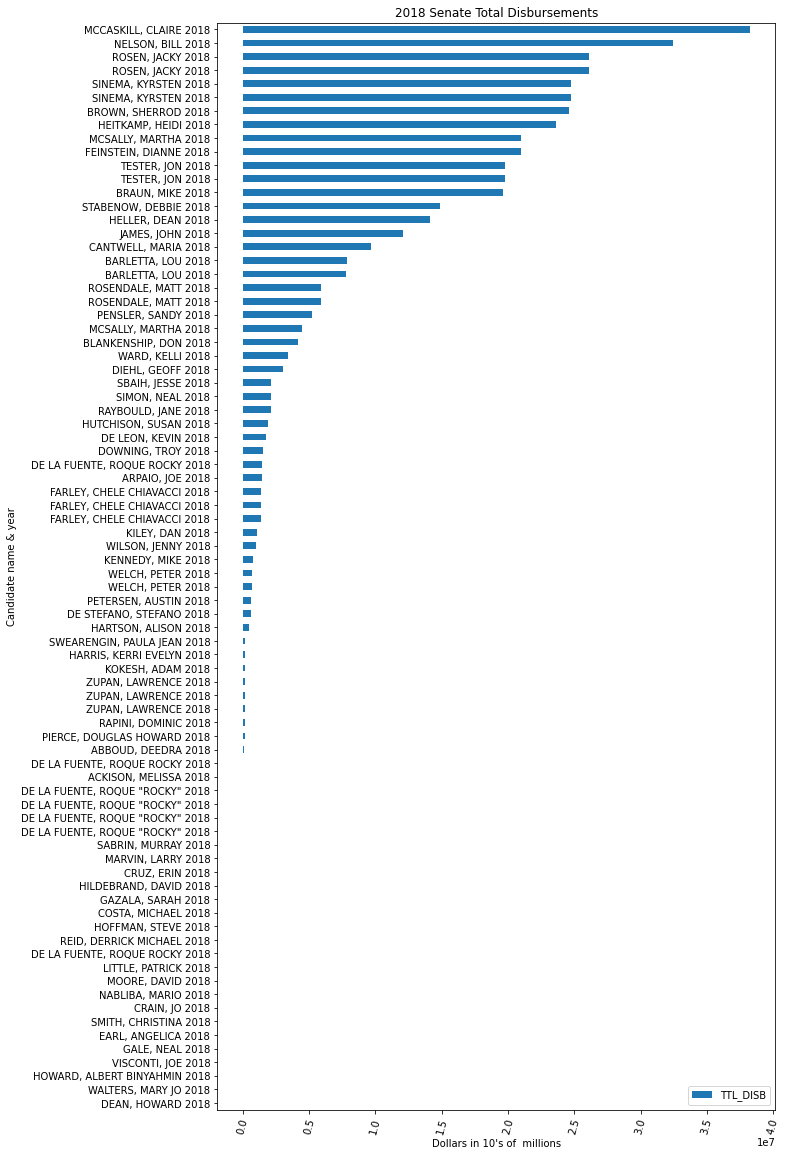

In [53]:
# df.groupby('Crime Name2').size().plot(kind='bar')
# sns.lineplot(data=honey_df, x='year', y='stocks', hue='state')
# honey_df.plot(x='year', y='priceperoz', kind='scatter')
plt.rcParams['figure.figsize'] = (10,20)
df.loc[df['year']==2018].sort_values(by='TTL_DISB').plot(x='nameyear', y = 'TTL_DISB', kind='barh')
plt.xticks(rotation=75)
plt.title('2018 Senate Total Disbursements')
plt.ylabel('Candidate name & year')
plt.xlabel('Dollars in 10\'s of  millions')

Okay so we know we can make plots. Let's look at just North Carolina for 2018 and if they won

Text(0.5, 0, "Dollars in 10's of  millions")

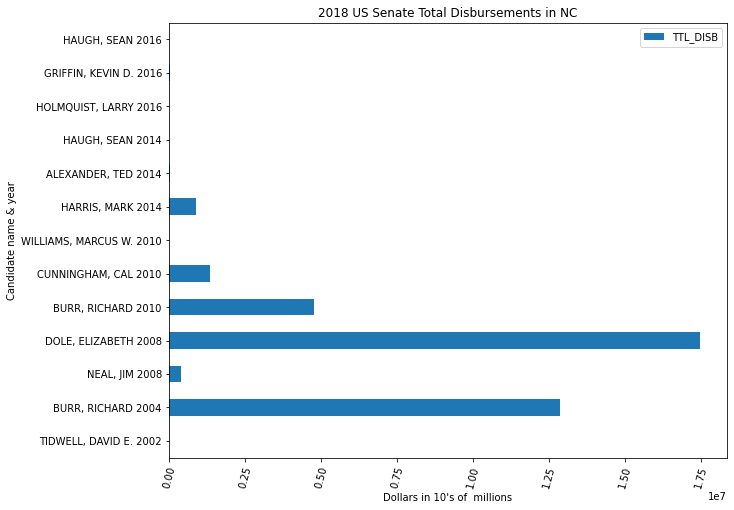

In [51]:
plt.rcParams['figure.figsize'] = (10,8)
# df.loc[(df['year']==2018) & (df['state' == 'North Carolina'])].sort_values(by='TTL_DISB').plot(x='nameyear', y = 'TTL_DISB', kind='bar')
df.loc[df['state'] == 'North Carolina'].sort_values(by='year').plot(x='nameyear', y = 'TTL_DISB', kind='barh')
plt.xticks(rotation=75)
plt.title('2018 US Senate Total Disbursements in NC')
plt.ylabel('Candidate name & year')
plt.xlabel('Dollars in 10\'s of  millions')

Well that is interesting, 2004 and 2008 were big disbursement years for Richard Burr and Elizabeth Dole. 
Let's check out total receipts next

Text(0, 0.5, "Dollars in 10's of  millions")

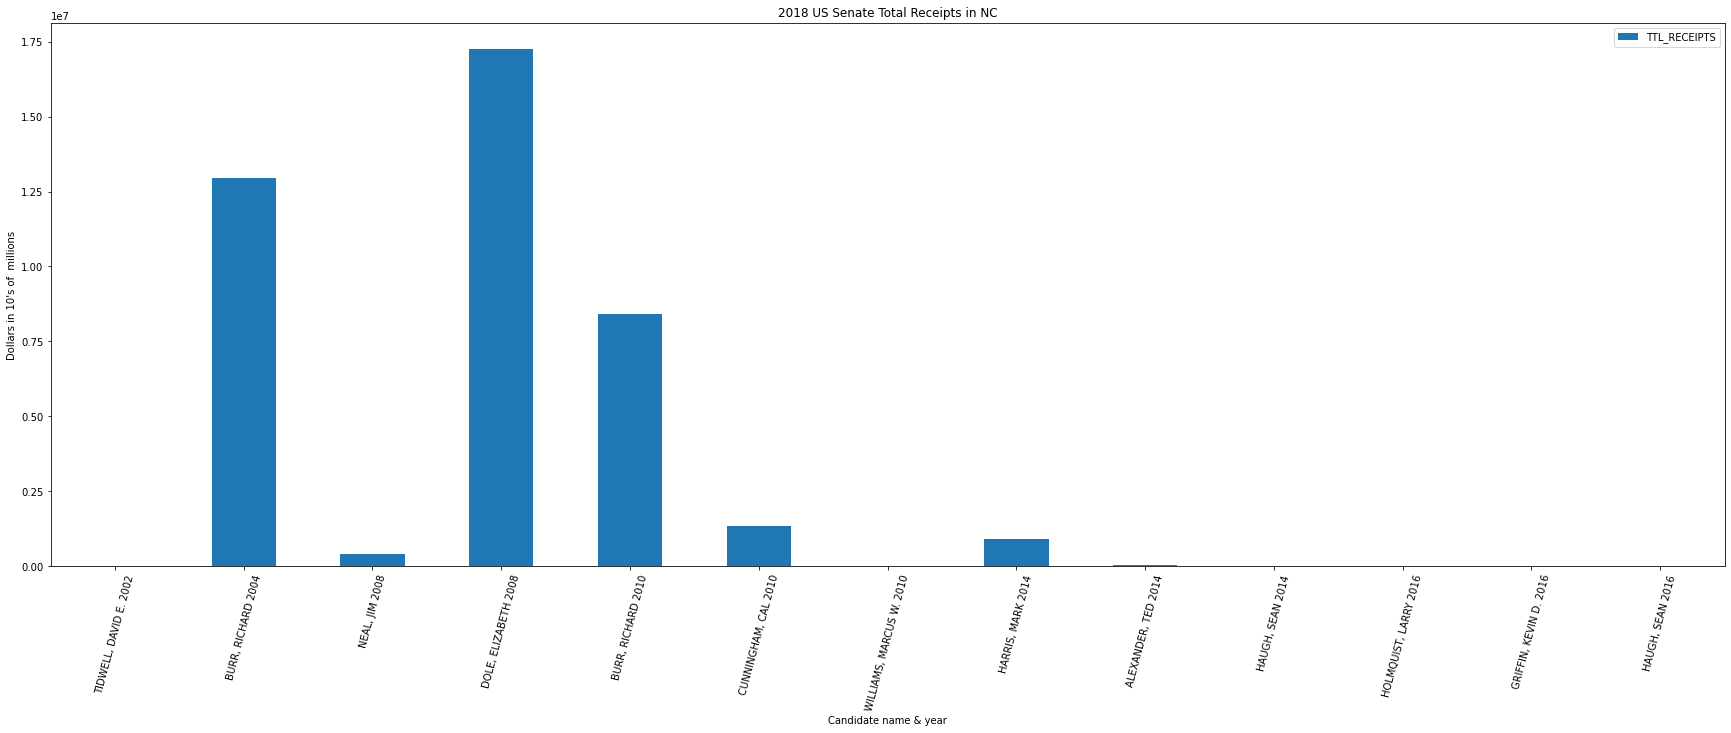

In [33]:
plt.rcParams['figure.figsize'] = (30,10)
# df.loc[(df['year']==2018) & (df['state' == 'North Carolina'])].sort_values(by='TTL_DISB').plot(x='nameyear', y = 'TTL_DISB', kind='bar')
df.loc[df['state'] == 'North Carolina'].sort_values(by='year').plot(x='nameyear', y = 'TTL_RECEIPTS', kind='bar')
plt.xticks(rotation=75)
plt.title('2018 US Senate Total Receipts in NC')
plt.xlabel('Candidate name & year')
plt.ylabel('Dollars in 10\'s of  millions')

Again, Richard Burr in 2004 and Elizabeth Dole in 2008. 
Richard Burr is also in third place again in 2010 for raising and spending money. 
Now did they win these years?

Text(0, 0.5, 'Percent of the votes')

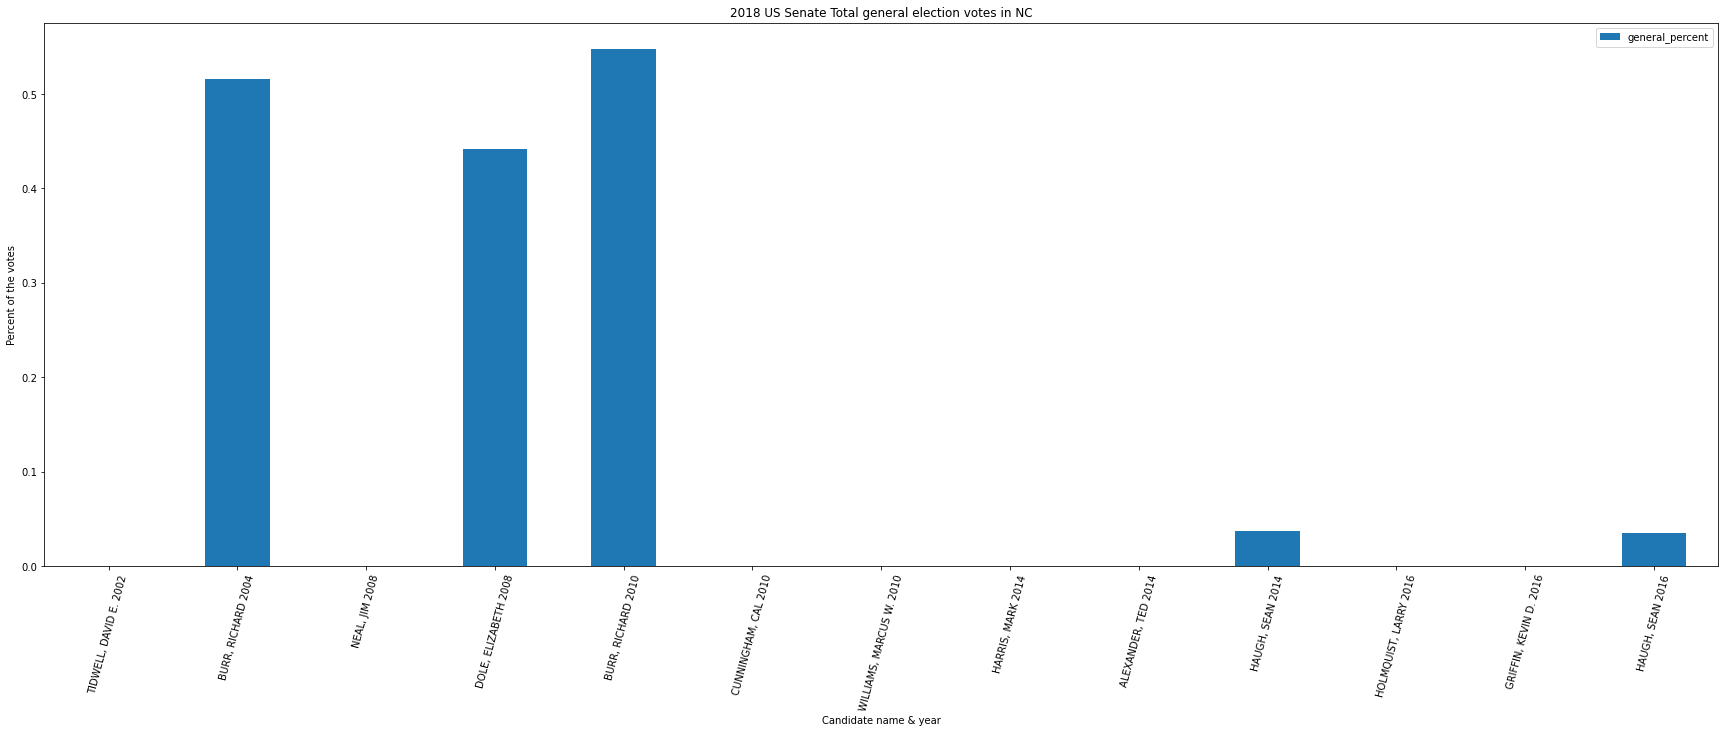

In [34]:
plt.rcParams['figure.figsize'] = (30,10)
# df.loc[(df['year']==2018) & (df['state' == 'North Carolina'])].sort_values(by='TTL_DISB').plot(x='nameyear', y = 'TTL_DISB', kind='bar')
df.loc[df['state'] == 'North Carolina'].sort_values(by='year').plot(x='nameyear', y = 'general_percent', kind='bar')
plt.xticks(rotation=75)
plt.title('2018 US Senate Total general election votes in NC')
plt.xlabel('Candidate name & year')
plt.ylabel('Percent of the votes')

They certainly are the only ones onboard for those years... 
I have just checked and we are indeed missing some people. In the financial set we have a 'HAGAN, KAY R' and in the senate results page they're named 'HAGAN, KAY'
I'm unsure how to fix this right now. So we are missing many many candidates from this review then.

I want to see if the Citizens United court case made an impact in 2010. I expect a huge increase of amounts starting in 2010.

Text(0.5, 0, "Dollars in 10's of  millions")

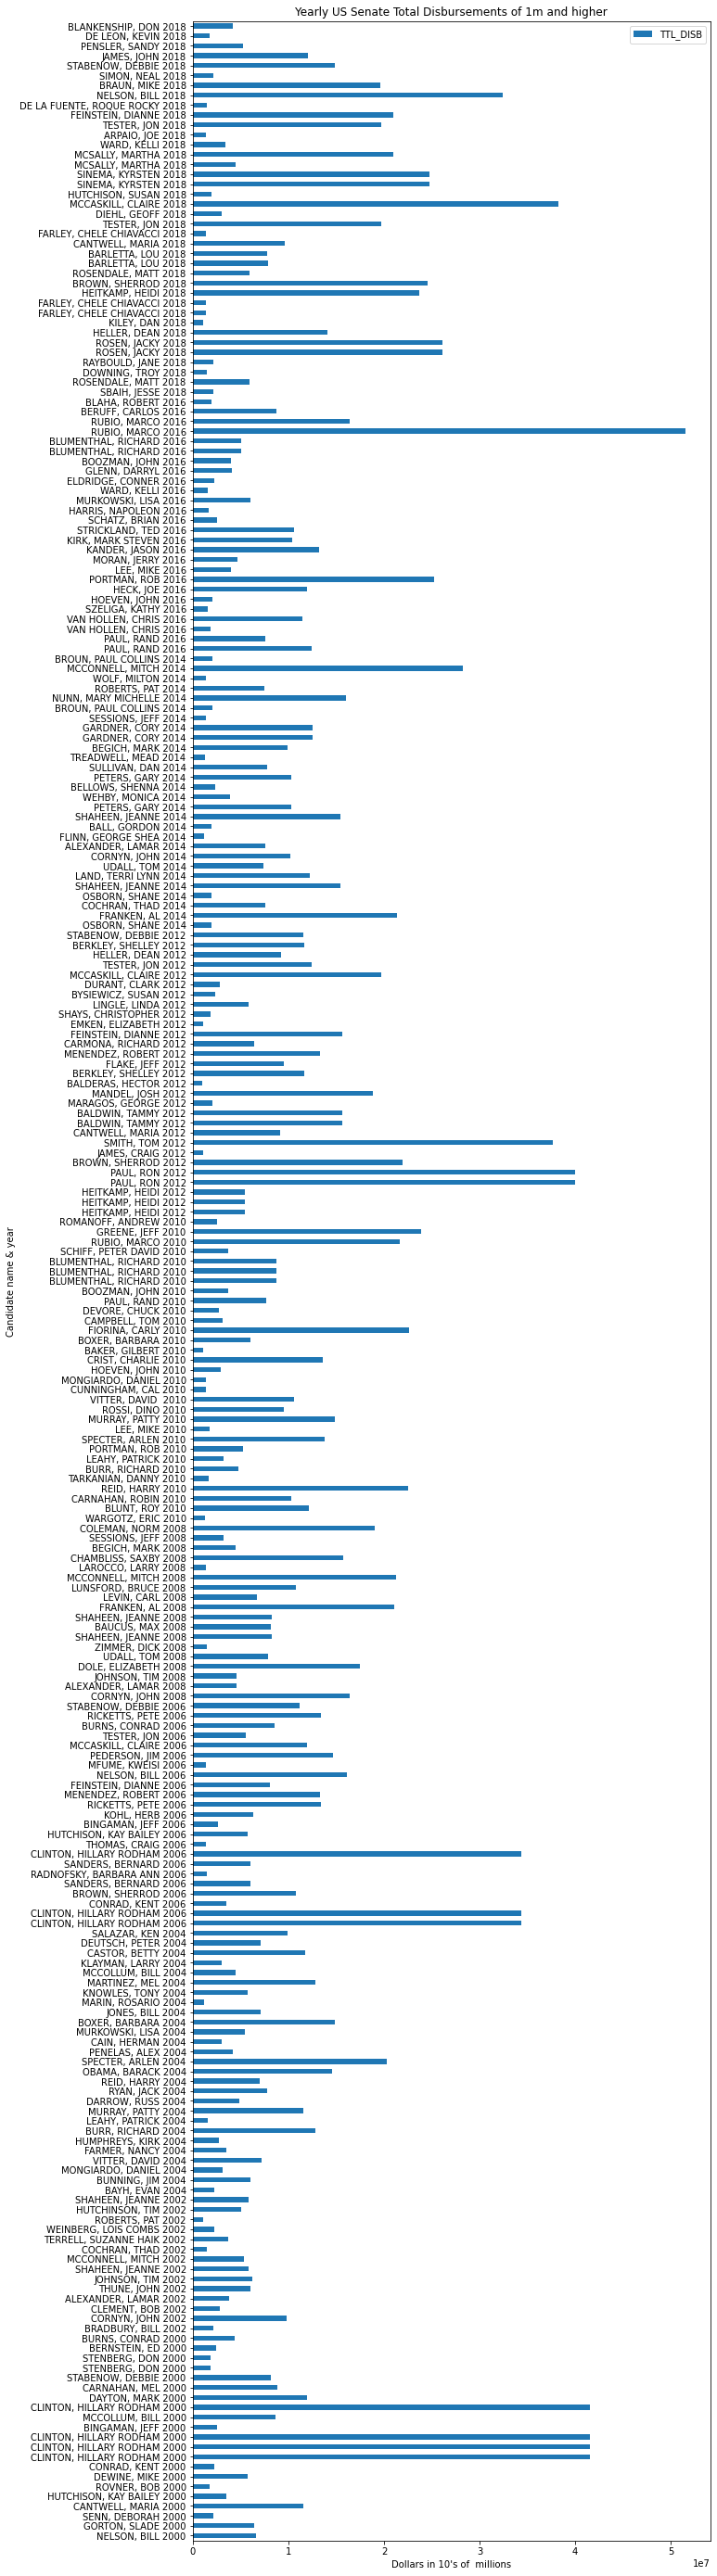

In [46]:
plt.rcParams['figure.figsize'] = (10,50)
df.loc[df['TTL_DISB']>=1000000].sort_values(by='year').plot(x='nameyear', y = 'TTL_DISB', kind='barh')
# plt.xticks(rotation=75)
plt.title('Yearly US Senate Total Disbursements of 1m and higher')
plt.ylabel('Candidate name & year')
plt.xlabel('Dollars in 10\'s of  millions')

Surprisingly...no. How about receipts?

Text(0.5, 0, "Dollars in 10's of  millions")

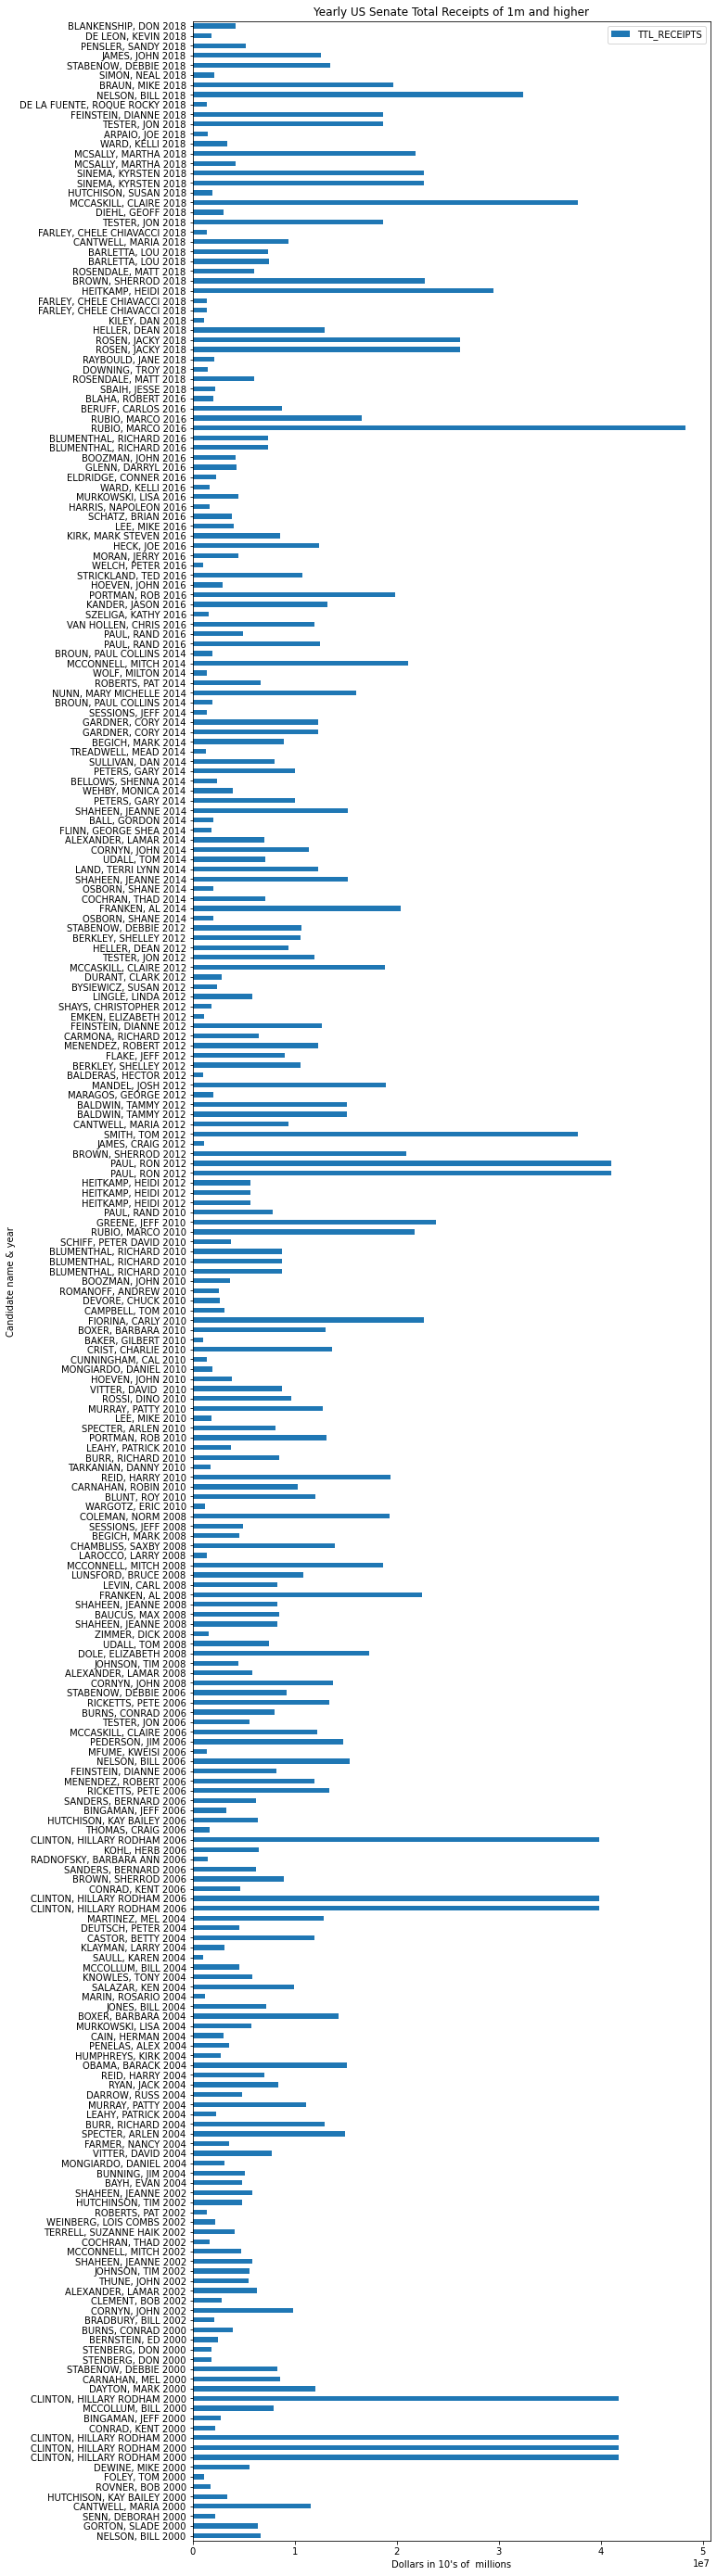

In [44]:
plt.rcParams['figure.figsize'] = (10,50)
df.loc[df['TTL_RECEIPTS']>=1000000].sort_values(by='year').plot(x='nameyear', y = 'TTL_RECEIPTS', kind='barh')
#plt.xticks(rotation=75)
plt.title('Yearly US Senate Total Receipts of 1m and higher')
plt.ylabel('Candidate name & year')
plt.xlabel('Dollars in 10\'s of  millions')

Also no, but there are a few landmark yers with high disbursements and receipts: 2000, 2006, 2012, 2016, and 2018.
I do wonder if those are just certain states' candidates being up for reelection.

What states have the most?

## This criterion is linked to a Learning OutcomeStorytelling
#### What have you learned? Tell a story around your visualizations.
#### Were you able to answer your initial problems/questions (if so, discuss that)?
---
First of all, there is a ton of money that goes into politics. Money flows in and out, millions of dollars.

When we look at the chart for NC in particular, we know that those candidates that raised the most money likely won. It's crazy to think that the person who raises the most will probably win.

My instinct is to say that those who raise substantially more will have a substantially higher chance of winning. But it's also worth considering the impact a states' population has on the amount of money in and out. For example, a large state such as NY, TX, or CA will have much more money flowing I imagine.

---

## Impact Section
#### Discuss the possible impact of your project. For example, how could your visualizations cause possible harm? What data or perspectives might be missing from this work?

###### We will not be checking for "right" or "wrong" answers, but showing your critical thinking. We understand some datasets may be more difficult to discuss than others - do your best!
---

The biggest impacts I can see would be for gambling... if one were to want to gamble on elections. But it is also worth seeing who/where the money is coming from and going, and I think it would be cool to make a graph chart or tree of somes sort to see the flow of money. 

This was difficult for me to do because of the inconsistencies between the dozens of files.

A possible harmful impact could be that if someone sees that a particular candidate has a substantial amount of money raised, more than their preferred candidate, is that they might not vote if they feel there is no point. "My vote won't matter they're not going to win anyways."

I'd like to also see the impact of the incumbent status on these as well.

---

#### Include any references.

---

* https://www.fec.gov/introduction-campaign-finance/election-and-voting-information/
* https://www.fec.gov/files/bulk-downloads/
* https://requests.readthedocs.io/en/latest/
* https://www.pythonpool.com/python-unzip/
* https://worldpopulationreview.com/states/state-abbreviations

---

#### Make sure to include your code somehow as well. You can do this in various ways. For example, you can include code snippets throughout your writing and/or include a link to your Jupyter notebook file.